# 实验二：torch.nn实现前馈神经网络
姓名：王恩泰

学号：21114019

# 一. 回归问题

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.nn import init
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

## 1. 读取数据

In [2]:
num_train, num_test = 700, 300
dim_w = 100

# 真实参数值
true_w = 2 * torch.ones(dim_w, 1)
true_b = 1

total_x = torch.randn((num_train+num_test, dim_w))
true_total_y = torch.matmul(total_x, true_w)+true_b
rand_total_y = torch.tensor(np.random.normal(0, 0.01, size=true_total_y.size()), dtype=torch.float) # 为生成的label添加随机扰动

train_x = total_x[:num_train, :]
train_y = rand_total_y[:num_train, :]
test_x = total_x[num_train:, :]
test_y = rand_total_y[num_train:, :]

batch_size = 10
train_dataset = Data.TensorDataset(train_x, train_y)
train_iter = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_dataset = Data.TensorDataset(test_x, test_y)
test_iter = Data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

## 2. 构建神经网络

In [3]:
# 1. 构建隐藏层类
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

# 2. 模型定义
num_inputs, num_outputs, num_hiddens = 100, 1, 50 # 100个输入参数，1个输出参数, 50个隐藏层
net = nn.Sequential(
         FlattenLayer(),
         nn.Linear(num_inputs, num_hiddens),
         nn.ReLU(),
         nn.Linear(num_hiddens, num_outputs),
         )
         
# 3. 初始化参数
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

# 4. 设置学习器参数
num_epochs=50
lr=0.01
# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss() # 只在MNIST中使用交叉熵，其它使用平方误差
optimizer = torch.optim.SGD(net.parameters(), lr)

## 3. 模型训练

iter: 0, train_loss= 0.000015, test_loss= 0.000011
iter: 10, train_loss= 0.000012, test_loss= 0.000011
iter: 20, train_loss= 0.000012, test_loss= 0.000011
iter: 30, train_loss= 0.000012, test_loss= 0.000011
iter: 40, train_loss= 0.000011, test_loss= 0.000011
iter: 49, train_loss= 0.000011, test_loss= 0.000011


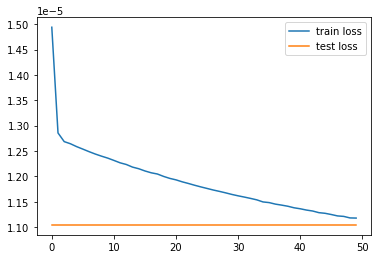

In [4]:
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    n_train = 0
    for train_x,train_y in train_iter: # 这里不用batch_size
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        l = loss(train_y, y_hat).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
    train_loss_list.append(train_loss_sum/n_train)

    test_loss_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        l = loss(test_y, y_hat.long()).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
    test_loss_list.append(test_loss_sum/n_test)
        
    if (epoch % 10 == 0):     
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 

# 二、二分类问题

## 1. 随机生成两类数据

In [5]:
n_data = torch.ones(1000, 20) # 1000*20的数据基本形态
x1 = torch.normal(2*n_data,1) # 均值为2，方差为1, 1000*20规格的随机数据（Feature）
y1 = torch.zeros(1000) # 1000个分到0类
x2 = torch.normal(-2*n_data,1) # 均值为-2，方差为1, 1000*20规格的随机数据（Feature）
y2 = torch.ones(1000) # 1000个分到1类

# 合并数据，把所有产生的x,0按行拼接
x_train_data = torch.cat((x1[0:700],x2[0:700]),0).type(torch.FloatTensor)
y_train_data = torch.cat((y1[0:700],y2[0:700]),0).type(torch.FloatTensor)
print(x_train_data.size())
print(y_train_data.size())

x_test_data = torch.cat((x1[700:1000],x2[700:1000]),0).type(torch.FloatTensor)
y_test_data = torch.cat((y1[700:1000],y2[700:1000]),0).type(torch.FloatTensor)
print(x_test_data.size())
print(y_test_data.size())

train_dataset = Data.TensorDataset(x_train_data, y_train_data)
test_dataset = Data.TensorDataset(x_test_data, y_test_data)
train_iter = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_iter = Data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

torch.Size([1400, 20])
torch.Size([1400])
torch.Size([600, 20])
torch.Size([600])


## 2. 构建神经网络

In [6]:
# 1. 构建隐藏层类
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

# 2. 模型定义
num_inputs, num_outputs, num_hiddens = 20, 1, 10 # 20个输入参数，1个输出参数, 50个隐藏层
net = nn.Sequential(
         FlattenLayer(),
         nn.Linear(num_inputs, num_hiddens),
         nn.ReLU(),
         nn.Linear(num_hiddens, num_outputs),
         )
         
# 3. 初始化参数
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

# 4. 设置学习器参数
num_epochs=50
lr=0.01
# loss = nn.CrossEntropyLoss()
loss = nn.MSELoss() # 只在MNIST中使用交叉熵，其它使用平方误差
optimizer = torch.optim.SGD(net.parameters(), lr)

## 3. 模型训练

iter: 0, train_loss= 0.012025, test_loss= 0.000595
iter: 0, train_acc= 0.854286, test_acc= 1.000000
iter: 10, train_loss= 0.000380, test_loss= 0.000395
iter: 10, train_acc= 1.000000, test_acc= 1.000000
iter: 20, train_loss= 0.000334, test_loss= 0.000352
iter: 20, train_acc= 1.000000, test_acc= 1.000000
iter: 30, train_loss= 0.000307, test_loss= 0.000331
iter: 30, train_acc= 1.000000, test_acc= 1.000000
iter: 40, train_loss= 0.000288, test_loss= 0.000320
iter: 40, train_acc= 1.000000, test_acc= 1.000000
iter: 49, train_loss= 0.000274, test_loss= 0.000300
iter: 49, train_acc= 1.000000, test_acc= 1.000000


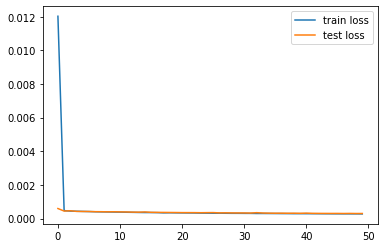

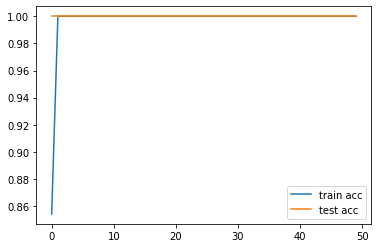

In [7]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    train_acc_sum = 0
    n_train = 0
    for train_x,train_y in train_iter: # 这里不用batch_size
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        y_hat = y_hat.squeeze(-1)
        l = loss(y_hat, train_y).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
        train_acc_sum += (y_hat.ge(0.5).float().squeeze() == train_y).sum().item()

    train_loss_list.append(train_loss_sum/n_train)
    train_acc_list.append(train_acc_sum/n_train)

    test_loss_sum = 0
    test_acc_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        y_hat = y_hat.squeeze(-1)
        l = loss(y_hat, test_y).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
        test_acc_sum += (y_hat.ge(0.5).float().squeeze() == test_y).sum().item()
    
    test_loss_list.append(test_loss_sum/n_test)
    test_acc_list.append(test_acc_sum/n_test)

    if (epoch % 10 == 0):   
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
        print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 

plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show() 

# 三、 多分类问题

## 1. 读取数据集

In [8]:
# 训练集
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets', train=True,
                                                download=False, transform=transforms.ToTensor())
# 测试集
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets', train=False,
                                                download=False, transform=transforms.ToTensor())

# 通过DataLoader读取小批量数据样本
batch_size = 256
num_workers = 0
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,
num_workers=num_workers)

## 2. 构建神经网络

In [9]:
# 1. 构建隐藏层类
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self,x):
        return x.view(x.shape[0],-1)

# 2. 模型定义
num_inputs, num_outputs, num_hiddens = 784, 10, 50 # 784个输入参数，10个输出参数（每类的概率）, 256个隐藏层
# 不同问题只需要根据输入输出更改输入层、输出层和隐藏层的数量即可
net = nn.Sequential(
         FlattenLayer(),
         nn.Linear(num_inputs, num_hiddens),
         nn.ReLU(),
         nn.Linear(num_hiddens, num_outputs),
         )
         
# 3. 初始化参数
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

# 4. 设置学习器参数
num_epochs=50
lr=0.01
loss = nn.CrossEntropyLoss()
# loss = nn.MSELoss() # 只在MNIST中使用交叉熵(已经考虑了取概率最大那个)，其它使用平方误差
optimizer = torch.optim.SGD(net.parameters(), lr)

## 3. 模型训练

iter: 0, train_loss= 0.008844, test_loss= 0.008557
iter: 0, train_acc= 0.197533, test_acc= 0.243900
iter: 10, train_loss= 0.002638, test_loss= 0.002703
iter: 10, train_acc= 0.758100, test_acc= 0.756800
iter: 20, train_loss= 0.002098, test_loss= 0.002211
iter: 20, train_acc= 0.818333, test_acc= 0.804600
iter: 30, train_loss= 0.001884, test_loss= 0.002020
iter: 30, train_acc= 0.834817, test_acc= 0.820800
iter: 40, train_loss= 0.001780, test_loss= 0.001933
iter: 40, train_acc= 0.843783, test_acc= 0.828000
iter: 49, train_loss= 0.001716, test_loss= 0.001881
iter: 49, train_acc= 0.848867, test_acc= 0.831900


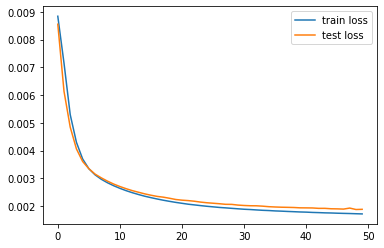

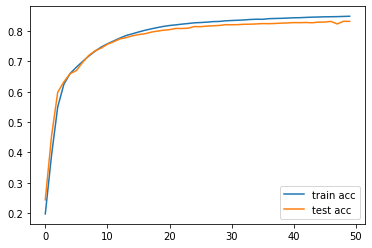

In [10]:
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
    train_loss_sum = 0
    train_acc_sum = 0

    n_train = 0
    for train_x,train_y in train_iter: # 这里不用batch_size
        y_hat = net(train_x)
        # print(y_hat)
        # print(train_y)
        l = loss(y_hat, train_y).sum()
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        if optimizer is None:
            SGD(params, lr)
        else:
            optimizer.step()
        train_loss_sum += l.item()
        n_train += train_y.shape[0]
        train_acc_sum += (y_hat.argmax(dim=1) == train_y).sum().item()
    train_loss_list.append(train_loss_sum/n_train)
    train_acc_list.append(train_acc_sum/n_train)

    test_loss_sum = 0
    test_acc_sum = 0
    n_test = 0
    for test_x,test_y in test_iter: 
        y_hat = net(test_x)
        l = loss(y_hat, test_y).sum()
        test_loss_sum += l.item()
        n_test += test_y.shape[0]
        test_acc_sum += (y_hat.argmax(dim=1) == test_y).sum().item()
    test_loss_list.append(test_loss_sum/n_test)
    test_acc_list.append(test_acc_sum/n_test)

    if (epoch % 10 == 0):
        print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
        print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
print('iter: %d, train_loss= %f, test_loss= %f' % (epoch, train_loss_sum/n_train, test_loss_sum/n_test))
print('iter: %d, train_acc= %f, test_acc= %f' % (epoch, train_acc_sum/n_train, test_acc_sum/n_test))
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show() 
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()